In [2]:
import pandas as pd

df = pd.read_csv('12월22일예측/test_1222.csv')

In [5]:
df = df[df['제안자']!='위원장'].reset_index()

In [11]:
df = df[df['제안자']!='정부'].reset_index()

In [12]:
correct = 0
for i in range(len(df)):
    if df.loc[i, '처리구분'] == df.loc[i, 'pred_classifier']:
        correct += 1
        
correct / len(df)

0.7985175202156334

In [14]:
df_21th = df[df['접수일자'] >= '2020-06-01']

In [17]:
del df_21th['level_0']
df_21th = df_21th.reset_index()

In [18]:
correct = 0
for i in range(len(df_21th)):
    if df_21th.loc[i, '처리구분'] == df_21th.loc[i, 'pred_classifier']:
        correct += 1
        
correct / len(df_21th)

0.811044003451251

In [3]:
df_21th = pd.read_csv('bills_21th_re.csv')

In [22]:
df.columns

Index(['Unnamed: 0', 'index', '의안번호', '임기대수', '법안코드', '법안명', '제안자', '소속정당',
       '당선횟수', '소속위1',
       ...
       '국회운영위원회', '국방위원회', '보건복지위원회', '법제사법위원회', '여성가족위원회', '산업통상자원중소벤처기업위원회',
       '기획재정위원회', '상임위원장 소속', 'MoonGov', 'num_seats'],
      dtype='object', length=110)

In [4]:
from gensim.models import Word2Vec as w2v
from eunjeon import Mecab
import pickle
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import re
import numpy as np
model = w2v.load('word2vec.model') #모델 불러오기



In [37]:
tagger = Mecab()

summary_re=[]
for text in tqdm(df_21th['제안내용']):
    try:
        summary_re.append(re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text))
    except:
        summary_re.append('NaN')
    
cnt_words = []
summary_re3 = []

for text in tqdm(summary_re):
    pos_text = tagger.pos(text)
    word_list = []
    for word in pos_text:
        word_list.append(word[0])
    cnt_words.append(len(word_list)+1)
    summary_re3.append(' '.join(word_list))
    
df_21th['제안내용_re']=summary_re3

100%|████████████████████████████████████████████████████████████████████████████| 6326/6326 [00:04<00:00, 1268.16it/s]


In [40]:
words = list()
for word in model.wv.vocab:
    words.append(word)


category = {'국회': ['의회', '국회'],
            '정당/선거': ['정당', '선거'] ,
            '안보': ['군사', '안보', '북한'], 
            '사법': ['사법', '법원', '검찰', '소송'],
            '행정' : ['행정', '지자체', '자치', '경찰', '공무원'],
            '재정' : ['재정', '예산', '회계'], 
            '중소기업' : ['중소기업', '창업', '벤처', '스타트업'],
            '에너지' : ['에너지', '수소', '전기', '가스'], 
            '부동산' : ['주택', '부동산', '주거', '임대차'], 
            '금융' : ['금융', '투자', '자본', '보험업'], 
            '자동차' : ['자동차', '승합자동차', '이륜자동차', '승용차'],
            '건설/기계/조선' : ['기계', '건설업', '건설사', '건축', '조선업', '해운업', '발주'],
            '유통/무역' : ['유통', '물류', '무역', '쇼핑몰', '마트', '백화점'], 
            'IT' : ['IT', '통신', '게임', '데이터', '인공지능', '블록체인', '클라우드'], 
            '농축산' : ['농업', '축산', '수산'],
            '복지':['복지', '연금', '빈곤', '수당'],
            '의료/보건' : ['의료', '보건', '병원', '질병', '의약품'] , 
            '도시/교통':['도시', '교통', '운전', '도로'],
            '교육' : ['교육', '학교', '대학', '유치원', '입시'], 
            '환경' : ['친환경', '오염', '저탄소', '온실가스', '기후', '수자원'], 
            '노동' : ['노동', '임금', '노동조합', '퇴직', '채용', '근로'], 
            '치안/안전' : ['치안', '범죄', '안전', '사고', '소방', '형사'],  
            '가족' : ['가족', '아동', '청소년'],
            '여성' : ['여성', '출산', '육아', '성범죄', '성희롱'], 
            '예체능' : ['예술', '영화', '음악', '전시','공연', '문화재', '체육', '방송', '언론', '스포츠', '콘텐츠']
            }


for key in category.keys():
    keyword_similar = np.zeros(shape=(len(words), ))
    
    for keyword in category[key]:
        keyword_similar_2 = []
        for word in words:
            sm = model.wv.similarity(keyword, word)
            if sm >= 0.8:
                keyword_similar_2.append(sm)
            else:
                keyword_similar_2.append(0)

        keyword_similar_2 = np.asarray(keyword_similar_2)
        keyword_similar += keyword_similar_2
    
    keyword_similar = list(keyword_similar)
    keyword_similar_df = pd.DataFrame({'words': words, 'similar' : keyword_similar})
    keyword_similar_df = keyword_similar_df.sort_values(by=['words'], axis=0)
    keyword_similar_df = keyword_similar_df.set_index('words')
    keyword_similar_df = keyword_similar_df.T

    vectorizer = CountVectorizer(vocabulary = keyword_similar_df.columns, binary=False)
    X = vectorizer.fit_transform(summary_re3)
    words_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
    words_df = words_df.T

    tdm = np.dot(keyword_similar_df, words_df)
    tdm = tdm.T
    tdm = np.ravel(tdm) #2차원 배열을 1차원으로 평평하게 만듬
    df_21th[key] = list(tdm / cnt_words)

In [49]:
df_21th.columns[111:137]

Index(['국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지', '부동산', '금융',
       '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건', '도시/교통', '교육',
       '환경', '노동', '치안/안전', '가족', '여성', '예체능'],
      dtype='object')

In [50]:
for i in range(len(df_21th)):    
    array = np.array(df_21th[df_21th.columns[111:137]][i:i+1])
    if array.sum() == 0:
        df_21th.loc[i, '분류'] = 25
        df_21th.loc[i, '분류값'] = 0
    else:
        df_21th.loc[i, '분류'] = array.argmax()
        df_21th.loc[i, '분류값'] = array[0][array.argmax()] * 100

In [33]:
#정당구별
#여당=0 제1야당=1 제3정당(바른미래당, 정의당, 민생당 등)=2 무소속 및 기타=3

for i in range(len(df_21th)):
    if df_21th.loc[i, '소속정당 구분'] == '더불어민주당' or df_21th.loc[i, '소속정당 구분'] == '열린민주당':
        df_21th.loc[i, 'party'] = 0
    elif df_21th.loc[i, '소속정당 구분'] == '국민의힘' or df_21th.loc[i, '소속정당 구분'] == '미래통합당' :
        df_21th.loc[i, 'party'] = 1
    elif df_21th.loc[i, '소속정당 구분'] == '국민의당' or df_21th.loc[i, '소속정당 구분'] == '기본소득당' or df_21th.loc[i, '소속정당 구분'] == '시대전환' or df_21th.loc[i, '소속정당 구분'] == '정의당':
        df_21th.loc[i, 'party'] = 2
    else:
        df_21th.loc[i, 'party'] = 3

In [52]:
len(df_21th)

6326

In [53]:
data = df_21th[['의안번호', '법안코드', '법안명', '제안자', '접수일자', '당선횟수', '공동발의자수',
       '입법형태', '선출형태', '처리구분', 'num_seats', 'party', '보건복지위원회',
       '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회',
       '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회',
       '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회',
       '국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지',
       '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건',
       '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성', '예체능']]

data = pd.get_dummies(data,columns=['입법형태','선출형태', 'party'])
data['id']=range(len(data))

col = list(data.columns)
col.remove('처리구분')
col.remove('id')
col.remove('접수일자')
col.remove('의안번호')
col.remove('제안자')
col.remove('법안명')
col.remove('법안코드')


In [54]:
columns = pd.read_csv('12월22일예측_2/feature_importances_1222_re.csv')

In [55]:
col = list(columns['var'])

In [5]:
file_name = "12월22일예측_2/bill_prediction_1222_re.pkl"
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [60]:
col = ['당선횟수', '공동발의자수', 'num_seats', '보건복지위원회', '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회', '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회', '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회', '국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지', '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건', '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성', '예체능', '입법형태_일부개정법률안', '입법형태_전부개정', '입법형태_제정', '선출형태_비례대표', '선출형태_지역구', 'party_0.0', 'party_1.0', 'party_2.0', 'party_3.0']
data['predictions'] = xgb_model_loaded.predict(data[col])

In [61]:
data.to_csv('21th_test.csv', encoding='utf-8-sig')

In [6]:
df = pd.read_csv('21th_test.csv')

In [7]:
col = ['당선횟수', '공동발의자수', 'num_seats', '보건복지위원회', '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회', '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회', '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회', '국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지', '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건', '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성', '예체능', '입법형태_일부개정법률안', '입법형태_전부개정', '입법형태_제정', '선출형태_비례대표', '선출형태_지역구', 'party_0.0', 'party_1.0', 'party_2.0', 'party_3.0']

In [11]:
#교차검증
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_model_loaded, df[col], df['처리구분'], scoring='neg_mean_squared_error', cv=5)
tree_rmse_scores = np.sqrt(-scores)

In [13]:
print(tree_rmse_scores.mean())
print(tree_rmse_scores.std())

0.40050666066687307
0.2085894513415354


In [14]:
tree_rmse_scores

array([0.78392406, 0.44365965, 0.3289461 , 0.23943047, 0.20657301])

In [121]:
#회의록 cnt 칼럼 추가해서 다시 모델 구축
import pandas as pd 
df = pd.read_csv('bill_preds_20_21th.csv')
df_re = pd.read_csv('df_bills_w_remarks_cnt_re2.csv')

In [123]:
df_re = df_re[['법안번호', '상임위 상정 여부', '반대당발언횟수']]

In [124]:
df_re = df_re.rename(columns={'법안번호':'법안코드'})

In [125]:
df2 = pd.merge(df, df_re, how='left', on='법안코드')

In [126]:
df2 = df2.fillna(0)

In [127]:
for i in range(len(df2)):
    if df2.loc[i, '제안자'] == '위원장':
        df2.loc[i, 'party'] = 4
    elif df2.loc[i, '제안자'] == '정부':
        df2.loc[i, 'party'] = 5

In [128]:
df2.to_csv('raw_data_1229_re2.csv', encoding='utf-8-sig')

In [17]:
#당직 여부 변수 만들기
import pandas as pd

df = pd.read_csv('raw_data_1229_re2.csv')
duty_df = pd.read_excel('당직.xlsx')

In [18]:
wduty_congressman = list(set(duty_df['의원']))

In [19]:
for i in range(len(df)):
    if df.loc[i, '제안자'] in wduty_congressman:
        df.loc[i, '당직여부'] = 1
    else:
        df.loc[i, '당직여부'] = 0

In [20]:
gender = pd.read_excel('의원_성별.xlsx') #여성의원목록

female = list(set(gender['의원']))

for i in range(len(df)):
    if df.loc[i, '제안자'] in female:
        df.loc[i, '의원_성별'] = 1 #대표발의 의원이 여성이면 1, 아니면 0
    else:
        df.loc[i, '의원_성별'] = 0

In [103]:
df.to_csv('bills_1231.csv', encoding='utf-8-sig')

In [133]:
for i in range(len(df)):
    df.loc[i, 'text_len'] = len(df.loc[i, '제안내용'])

In [107]:
for i in range(len(df)):
    if df.loc[i, '접수일자'] >= '2020-05-30':
        df.loc[i, '대수'] = 21
    else:
        df.loc[i, '대수'] = 20

In [165]:
data = df[['의안번호', '법안코드', '법안명', '제안자', '접수일자', '당선횟수', '공동발의자수',
       '입법형태', '선출형태', '처리구분', 'num_seats', 'party', '보건복지위원회',
       '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회',
       '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회',
       '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회',
       '국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지',
       '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건',
       '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성', '예체능','상임위 상정 여부', '반대당발언횟수']]

data = pd.get_dummies(data,columns=['입법형태','선출형태', 'party','상임위 상정 여부'])
data['id']=range(len(data))

train = data.sample(13246,replace=False,random_state=2020).reset_index().drop(['index'],axis=1)
test = data.loc[ ~data['id'].isin(train['id']) ].reset_index().drop(['index'],axis=1)

col = list(data.columns)
col.remove('처리구분')
col.remove('id')
col.remove('접수일자')
col.remove('의안번호')
col.remove('제안자')
col.remove('법안명')
col.remove('법안코드')

In [166]:
from xgboost import XGBClassifier
xgb = XGBClassifier( n_estimators = 400, learning_rate = 0.05, max_depth = 7, 
                    random_state=2020, verbosity =0, scale_pos_weight =1.2, reg_alpha=1,
                   num_parallel_tree=1, tree_method='exact')
xgb.fit(train[col], train['처리구분'])
predictions = xgb.predict(test[col])
(pd.Series(predictions)==test['처리구분']).mean()

0.8085748792270532

In [158]:
feature_imp = xgb.feature_importances_
imp_df = pd.DataFrame({'var':col,
                        'imp':feature_imp})

imp_df.sort_values(['imp'],ascending=False)

,var,imp
58,상임위 상정 여부_0.0,0.186912
56,party_4.0,0.131455
46,반대당발언횟수,0.122576
14,농림축산식품해양수산위원회,0.048355
11,기획재정위원회,0.034375
20,정무위원회,0.032922
8,법제사법위원회,0.023482
22,정당/선거,0.021373
48,입법형태_전부개정,0.017801
1,공동발의자수,0.017531


In [159]:
imp_df = imp_df.sort_values(['imp'],ascending=False)
imp_df.to_csv('feature_importances_1231_re.csv', encoding='utf-8-sig')

In [172]:
!pip install graphviz 

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

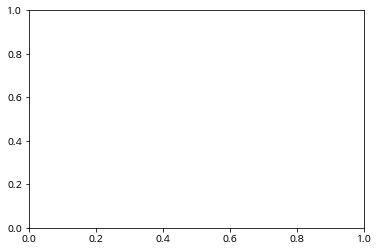

In [173]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

plot_tree(xgb)
plt.show()

In [2]:
import pandas as pd

df = pd.read_csv('12월31일예측/bills_1231.csv')
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', '의안번호', '법안코드', '법안명',
       '제안자', '접수일자', '당선횟수', '공동발의자수', '입법형태', '선출형태', '처리구분', 'num_seats',
       'party', '상임위원장 소속', '보건복지위원회', '행정안전위원회', '산업통상자원중소벤처기업위원회',
       '문화체육관광위원회', '국회운영위원회', '법제사법위원회', '국방위원회', '국토교통위원회', '기획재정위원회',
       '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회', '외교통일위원회', '정보위원회',
       '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회', '제안내용', '제안내용_re', '국회',
       '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지', '부동산', '금융', '자동차',
       '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건', '도시/교통', '교육', '환경',
       '노동', '치안/안전', '가족', '여성', '예체능', '분류', '분류값', '상임위 상정 여부', '반대당발언횟수',
       '당직여부', '의원_성별'],
      dtype='object')

In [5]:
import pickle

xgb_model_loaded = pickle.load(open("12월31일예측/bill_prediction_1231.pkl", "rb"))

In [6]:
data = df[['의안번호', '법안코드', '법안명', '제안자', '접수일자', '당선횟수', '공동발의자수',
       '입법형태', '선출형태', '처리구분', 'num_seats', 'party', '보건복지위원회',
       '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회',
       '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회',
       '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회',
       '국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지',
       '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건',
       '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성', '예체능','상임위 상정 여부', '반대당발언횟수']]

data = pd.get_dummies(data,columns=['입법형태','선출형태', 'party','상임위 상정 여부'])
data['id']=range(len(data))

col = list(data.columns)
col.remove('처리구분')
col.remove('id')
col.remove('접수일자')
col.remove('의안번호')
col.remove('제안자')
col.remove('법안명')
col.remove('법안코드')


from xgboost import XGBRegressor
xgb = XGBRegressor( n_estimators = 400, learning_rate = 0.05, max_depth = 6,  objective='binary:logistic', 
                    random_state=2020, verbosity =0, scale_pos_weight =1.2, reg_alpha=1,
                   num_parallel_tree=1, tree_method='exact' )
xgb.fit(data[col], data['처리구분'])


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=2020, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1.2, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)

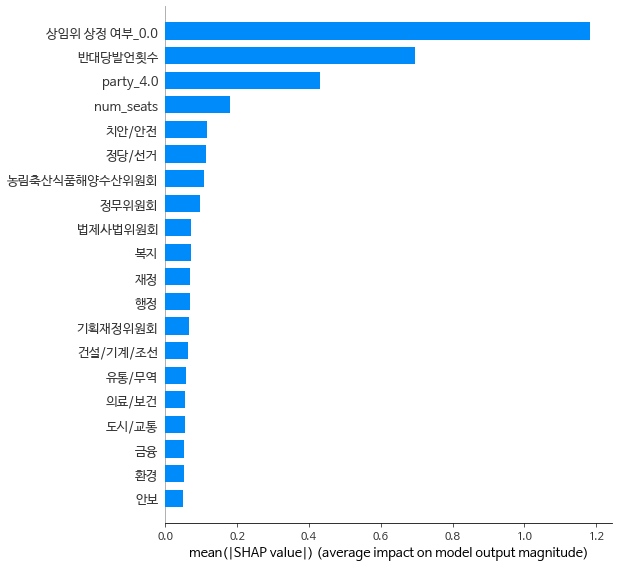

In [79]:
import shap

from matplotlib import font_manager, rc
import platform 
import matplotlib.pyplot as plt
%matplotlib inline

# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'C:/Users/user/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')


explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values( data[col] )
shap.summary_plot( shap_values , data[col] , plot_type="bar" )

invalid value encountered in true_divide
invalid value encountered in true_divide


<Figure size 432x288 with 0 Axes>

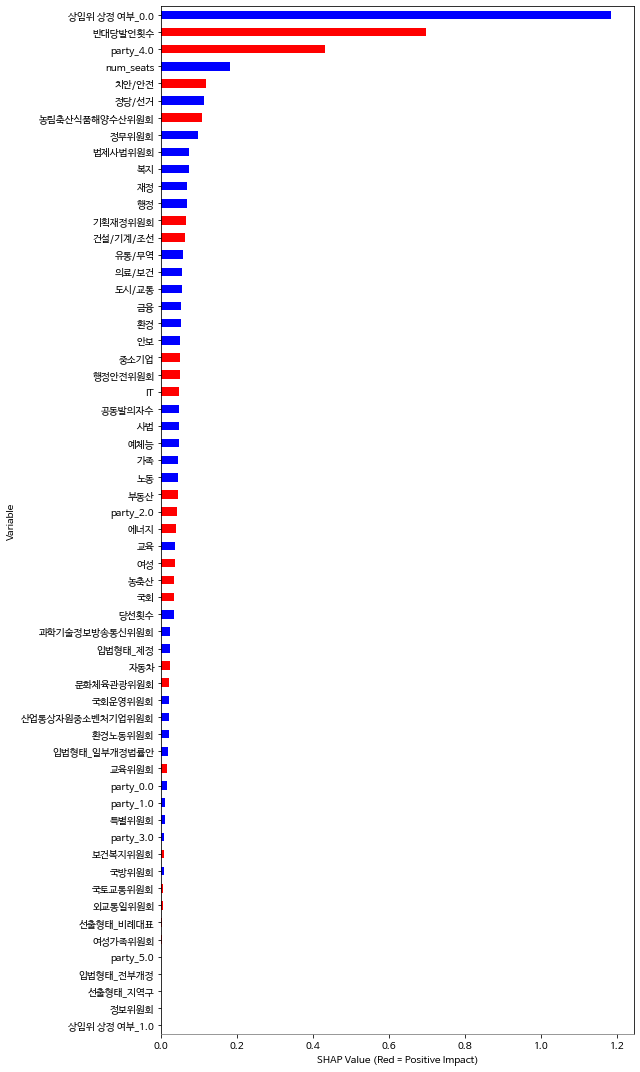

In [31]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    fig = plt.gcf()
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(9,15), legend=False)
    ax.spines['bottom'].set_color('gray')
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    plt.tight_layout()
    plt.savefig("shap_values.png", dpi=500)
    
ABS_SHAP(shap_values,data[col]) 

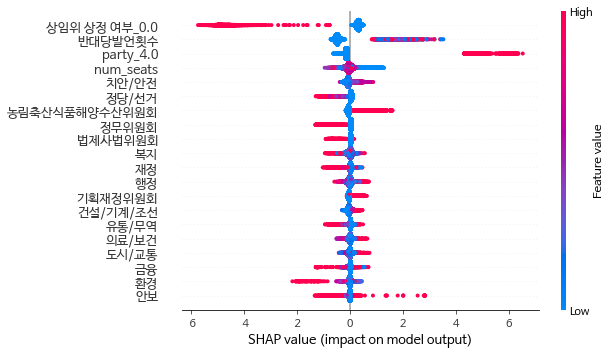

AttributeError: 'NoneType' object has no attribute 'set_xlim'

In [88]:
import shap


# 한글 폰트 사용
if platform.system() == 'Windows': 
    path = 'C:/Users/user/AppData/Local/Microsoft/Windows/Fonts/NanumBarunGothic.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')

shap.summary_plot(shap_values, data[col],plot_type = "dot", plot_size=0.2  )


In [76]:
np.min(shap_values)

-5.7338123

In [66]:

delta = 1.0 / (shap_values.shape[1] ** 2)
slow = np.nanpercentile(shap_values, delta)
shigh = np.nanpercentile(shap_values, 100 - delta)

In [73]:
v = max(abs(slow), abs(shigh))
-v

-6.3513002153830005

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


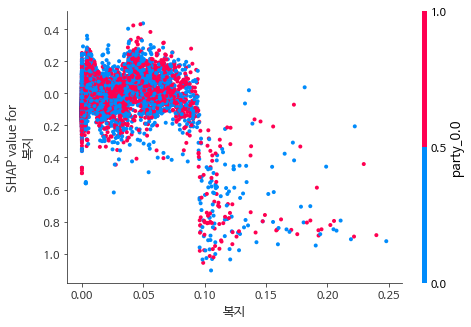

In [160]:
shap.dependence_plot( '복지' , shap_values , train[col]  , interaction_index='party_0.0')

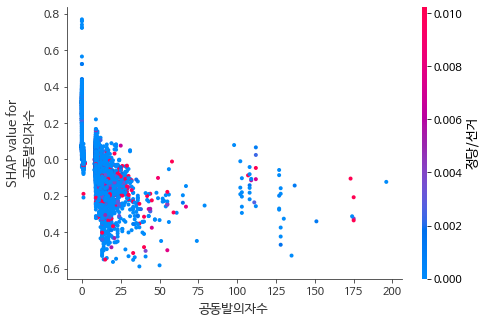

In [162]:
shap.dependence_plot( '공동발의자수' , shap_values , train[col] , interaction_index='정당/선거')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


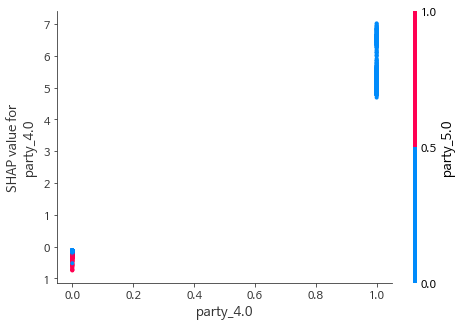

In [162]:
shap.dependence_plot( 'party_4.0' , shap_values , train[col]  )

In [17]:
shap.initjs()
shap.force_plot( explainer.expected_value , shap_values[1178] , data[col].iloc[1178] )

In [14]:
data[data['반대당발언횟수']>100]

,의안번호,법안코드,법안명,제안자,접수일자,당선횟수,공동발의자수,처리구분,num_seats,보건복지위원회,...,선출형태_지역구,party_0.0,party_1.0,party_2.0,party_3.0,party_4.0,party_5.0,상임위 상정 여부_0.0,상임위 상정 여부_1.0,id
579,2014964,PRC_Z1R8V0J8Y2V1L1R0Y2E8A2E9G7K9N2,대·중소기업 상생협력 촉진에 관한 법률 일부개정법률안(어기구의원 등 19인),어기구,2018-08-21,1.0,18,0,129.0,0,...,1,1,0,0,0,0,0,0,1,579
834,2015206,ARC_Z1R8C0A8J3A1K1V3B3X1R4A0C1F9D2,소득세법 일부개정법률안(정부),정부,2018-08-31,0.0,0,1,0.0,0,...,1,0,0,0,0,0,1,0,1,834
1178,2015611,PRC_H1K8O0R9V1J8W1M6Z3S0P2B1T7L9Z3,지방행정동우회법안(정태옥의원 등 13인),정태옥,2018-09-18,1.0,12,1,7.0,0,...,1,0,0,0,1,0,0,0,1,1178
1508,2015944,PRC_M1R8Q1X0I1M0M1U4D2K7O1D1R8V7O4,고등교육법 일부개정법률안(이찬열의원 등 14인),이찬열,2018-10-10,3.0,13,1,27.0,0,...,1,0,0,1,0,0,0,0,1,1508
1607,2016045,PRC_H1H8K1D0M2C3U1E7W4S6T5D4I6I2R0,유아교육법 일부개정법률안(박용진의원 등 129인),박용진,2018-10-23,1.0,128,0,129.0,0,...,1,1,0,0,0,0,0,0,1,1607
1655,2016093,ARC_N1H8B1Y0U2C6H1D5V1V0X0Z8G4P2Y8,중앙행정권한 및 사무 등의 지방 일괄 이양을 위한 물가안정에 관한 법률 등 66개 ...,정부,2018-10-26,0.0,0,1,0.0,0,...,1,0,0,0,0,0,1,0,1,1655
1831,2016250,ARC_S1G8U1J1B0P1E1F3F5Q0J2R6F1N3P9,산업안전보건법 전부개정법률안(정부),정부,2018-11-01,0.0,0,1,0.0,0,...,1,0,0,0,0,0,1,0,1,1831
1874,2016326,PRC_U1C8R1C1K0N2Z1P9O5Q2J0X4I0P4M4,농업인 태양광 발전사업 지원에 관한 법률안(정운천의원 등 15인),정운천,2018-11-02,1.0,14,0,27.0,0,...,0,0,0,1,0,0,0,0,1,1874
2029,2016473,PRC_I1E8N1P1R0C9D1C6I1I4D4I1N1M0C4,대·중소기업 상생협력 촉진에 관한 법률 일부개정법률안(권칠승의원 등 10인),권칠승,2018-11-09,1.0,9,0,129.0,0,...,1,1,0,0,0,0,0,0,1,2029
2072,2016519,PRC_Q1K8Z1Y1M1J3J1B1J3Q2N0R3B1Q1N1,한국광업공단법안(홍영표의원 등 16인),홍영표,2018-11-13,3.0,15,0,129.0,0,...,1,1,0,0,0,0,0,0,1,2072


In [164]:
from sklearn.model_selection import cross_val_score
xgb = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 7, 
                    random_state=2020, verbosity =0, scale_pos_weight =1.2, reg_alpha=1,
                   num_parallel_tree=1, tree_method='exact')

scores = cross_val_score(xgb, train[col], train['처리구분'], scoring='accuracy', cv=5)
print(scores.mean())
print(scores.std())

0.8456891813927647
0.00630703817873774


In [113]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

params = [
    {'n_estimators': [200, 300, 400],
    'learning_rate': [0.05],
    'max_depth':[6,7],
    'scale_pos_weight':[1.2, 2.6],
    'reg_alpha': [0, 1, 2]}    
]

xgb = XGBClassifier()

grid_search = GridSearchCV(xgb, params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(train[col], train['처리구분'])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [114]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 7,
 'n_estimators': 400,
 'reg_alpha': 1,
 'scale_pos_weight': 1.2}

In [100]:
from xgboost import XGBRegressor
xgb = XGBRegressor( n_estimators = 400, learning_rate = 0.05, max_depth = 6,  objective='binary:logistic', 
                    random_state=2020, verbosity =0, scale_pos_weight =1.2, reg_alpha=1,
                   num_parallel_tree=1, tree_method='exact' )
xgb.fit(train[col], train['처리구분'])

test['predictions'] = xgb.predict(test[col])


In [101]:
import pickle
file_name = "bill_prediction_1231.pkl"

# save
pickle.dump(xgb, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [102]:
test.to_csv('test_1231.csv', encoding='utf-8-sig')

In [86]:
col = ['당선횟수', '공동발의자수', 'num_seats', '보건복지위원회', '행정안전위원회', '산업통상자원중소벤처기업위원회', '문화체육관광위원회', '국회운영위원회', '법제사법위원회', '국방위원회', '국토교통위원회', '기획재정위원회', '특별위원회', '여성가족위원회', '농림축산식품해양수산위원회', '외교통일위원회', '정보위원회', '과학기술정보방송통신위원회', '환경노동위원회', '교육위원회', '정무위원회', '국회', '정당/선거', '안보', '사법', '행정', '재정', '중소기업', '에너지', '부동산', '금융', '자동차', '건설/기계/조선', '유통/무역', 'IT', '농축산', '복지', '의료/보건', '도시/교통', '교육', '환경', '노동', '치안/안전', '가족', '여성', '예체능', '반대당발언횟수', '입법형태_일부개정법률안', '입법형태_전부개정', '입법형태_제정', '선출형태_비례대표', '선출형태_지역구', 'party_0.0', 'party_1.0', 'party_2.0', 'party_3.0', 'party_4.0', 'party_5.0', '상임위 통과 여부_0.0', '상임위 통과 여부_1.0']
test['predictions'] = xgb_model_loaded.predict(test[col])
test.to_csv('test_1229_try.csv', encoding='utf-8-sig')

In [98]:
t_re = test[test['제안자']!='위원장']
t_re = t_re[t_re['제안자']!='정부']

In [99]:
acc = 0

t_re = t_re.reset_index()
for i in range(len(t_re)):
    if t_re.loc[i, 'predictions'] >= 0.5 and t_re.loc[i, '처리구분'] == 1:
        acc += 1
    elif t_re.loc[i, 'predictions'] < 0.5 and t_re.loc[i, '처리구분'] == 0:
        acc += 1
        
acc/len(t_re)

0.7806603773584906

In [94]:
t_re

,index,의안번호,법안코드,법안명,제안자,접수일자,당선횟수,공동발의자수,처리구분,num_seats,...,선출형태_비례대표,선출형태_지역구,party_0.0,party_1.0,party_2.0,party_3.0,party_4.0,party_5.0,id,predictions
0,0,2014408,PRC_T1R8O0I7Z1E3F1W7L2D3O0J5A3W5D2,농어촌주민의 보건복지 증진을 위한 특별법 일부개정법률안(경대수의원 등 10인),경대수,2018-07-13,2.0,9,1,115.0,...,0,1,0,1,0,0,0,0,24,0.002305
1,1,2014401,PRC_V1M8A0Y7Q1E3M1C6N3Q8T3V4B5M9Q1,노인복지법 일부개정법률안(경대수의원 등 10인),경대수,2018-07-13,2.0,9,0,115.0,...,0,1,0,1,0,0,0,0,25,0.000080
2,2,2014384,PRC_T1K8M0Q7P1M3C1S3I3B2W5G5G0O5R7,약사법 일부개정법률안(김승희의원 등 10인),김승희,2018-07-13,1.0,9,1,115.0,...,1,0,0,1,0,0,0,0,33,0.000148
3,3,2014435,PRC_B1D8Z0O7P1O6E1I8L2Q4Y4W2O3Q1U8,기간제 및 단시간근로자 보호 등에 관한 법률 일부개정법률안(박광온의원 등 10인),박광온,2018-07-16,2.0,9,0,129.0,...,0,1,1,0,0,0,0,0,51,0.000114
4,4,2014433,PRC_Z1L8T0G7U1E6P1F8T2M2N4K8R8Q8F0,근로기준법 일부개정법률안(박광온의원 등 10인),박광온,2018-07-16,2.0,9,0,129.0,...,0,1,1,0,0,0,0,0,52,0.000058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,3307,2106483,PRC_W2N0S1G2F1K5V1P7E0H6W4A4N6F3G2,취업 후 학자금 상환 특별법 일부개정법률안(정청래의원 등 17인),정청래,2020-12-15,3.0,16,0,185.0,...,0,1,1,0,0,0,0,0,16519,0.000142
3094,3308,2106467,PRC_X2K0Q1N2Q1P5Y1X5I1J6E0R8B0S3U1,북한이탈주민의 보호 및 정착지원에 관한 법률 일부개정법률안(한정애의원 등 10인),한정애,2020-12-15,3.0,9,0,185.0,...,0,1,1,0,0,0,0,0,16535,0.000084
3095,3309,2106461,PRC_H2P0L1X2I0D1Q1Z5D2H9J1J5Z1F3V5,환경친화적 자동차의 개발 및 보급 촉진에 관한 법률 일부개정법률안(강은미의원등10인),강은미,2020-12-15,0.0,0,0,0.0,...,0,1,0,0,0,1,0,0,16541,0.000953
3096,3310,2106456,PRC_I2B0D1J2B0T7H1X1E2G9P3F8I1K6L5,의료법 일부개정법률안(신현영의원등14인),0,2020-12-15,0.0,1,0,0.0,...,0,1,0,0,0,1,0,0,16546,0.000060
